In [1]:
### Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# Start spark session
from pyspark.sql import SparkSession

spark = SparkSession.builder.config("spark.driver.memory", "14g").getOrCreate()

24/08/14 16:34:52 WARN Utils: Your hostname, ubuntu20 resolves to a loopback address: 127.0.1.1; using 192.168.0.234 instead (on interface wlp0s20f3)
24/08/14 16:34:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/14 16:34:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Load data

In [3]:
# Load rating dataset
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

schema = StructType([
    StructField("user_id", IntegerType(), True),
    StructField("Username", StringType(), True),
    StructField("anime_id", IntegerType(), True),
    StructField("Anime Title", StringType(), True),
    StructField("rating", IntegerType(), True)])

df = spark.read.csv('../dataset/myanimelist-dataset/processed-dataset/users-score-2023.csv', header=True, schema=schema)

In [4]:
df.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- Username: string (nullable = true)
 |-- anime_id: integer (nullable = true)
 |-- Anime Title: string (nullable = true)
 |-- rating: integer (nullable = true)



In [5]:
df.show(10)

+-------+--------+--------+--------------------+------+
|user_id|Username|anime_id|         Anime Title|rating|
+-------+--------+--------+--------------------+------+
|      1|   Xinil|      21|           One Piece|     9|
|      1|   Xinil|      48|         .hack//Sign|     7|
|      1|   Xinil|     320|              A Kite|     5|
|      1|   Xinil|      49|    Aa! Megami-sama!|     8|
|      1|   Xinil|     304|Aa! Megami-sama! ...|     8|
|      1|   Xinil|     306|Abenobashi Mahou☆...|     8|
|      1|   Xinil|      53|       Ai Yori Aoshi|     7|
|      1|   Xinil|      47|               Akira|     5|
|      1|   Xinil|     591|      Amaenaide yo!!|     6|
|      1|   Xinil|      54|   Appleseed (Movie)|     7|
+-------+--------+--------+--------------------+------+
only showing top 10 rows



In [6]:
df.count()

24321734

In [7]:
# Calculating the average score
df.agg({ "rating": "avg"}).show()

+-----------------+
|      avg(rating)|
+-----------------+
|7.623071159317835|
+-----------------+



In [8]:
# Count the number of distinct users who have ratings
num_users = df.select("user_id").distinct().count()
num_users

270031

In [9]:
# Count the number of distinct rated animes
num_animes = df.select("anime_id").distinct().count()
num_animes

16497

In [10]:
# Calculate sparsity
num_ratings = df.count()
print("Number of ratings: ", num_ratings)

total_expect_rating = num_users * num_animes
sparsity = (total_expect_rating - num_ratings) / total_expect_rating
print("Sparsity: ", sparsity)

Number of ratings:  24321734
Sparsity:  0.994540210043757


# Collaborative Filtering

### Training

In [4]:
(train_set, test_set) = df.randomSplit([0.8, 0.2], seed=1256)

In [12]:
print("Number of samples in training set: ", train_set.count())
print("Number of samples in test set: ", test_set.count())

Number of samples in training set:  19455312


Number of samples in test set:  4866422


In [14]:
# Some parameters for ALS
RANK = 10
MAX_ITER = 10
REG_PARAM = 1.0

In [5]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

# Build the recommendation model using ALS on the training data
als = ALS(userCol="user_id", itemCol="anime_id", ratingCol="rating",
          coldStartStrategy="drop")

In [16]:
model = als.fit(train_set)

24/07/25 12:34:49 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/07/25 12:34:50 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [17]:
# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test_set)

In [18]:
predictions.show(5)

+-------+--------+--------+--------------------+------+----------+
|user_id|Username|anime_id|         Anime Title|rating|prediction|
+-------+--------+--------+--------------------+------+----------+
|      1|   Xinil|       5|Cowboy Bebop: Ten...|     8|  8.093723|
|      1|   Xinil|      19|             Monster|     9|  8.411947|
|      1|   Xinil|      30|Neon Genesis Evan...|    10| 7.5512943|
|      1|   Xinil|      53|       Ai Yori Aoshi|     7| 6.8196783|
|      1|   Xinil|      60|       Chrno Crusade|     8| 7.3844004|
+-------+--------+--------+--------------------+------+----------+
only showing top 5 rows



In [19]:
evaluator = RegressionEvaluator(
    metricName="rmse", 
    labelCol="rating", 
    predictionCol="prediction"
)
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 1.2344622964227925


### Load dataset for recommendation

In [21]:
# Load anime dataset
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, StringType

schema = StructType([
    StructField("anime_id", IntegerType(), True),
    StructField("Name", StringType(), True),
    StructField("English name", StringType(), True),
    StructField("Other name", StringType(), True),
    StructField("Score", FloatType(), True),
    StructField("Genres", StringType(), True),
    StructField("Synopsis", StringType(), True),
    StructField("Type", StringType(), True),
    StructField("Episodes", FloatType(), True),
    StructField("Aired", StringType(), True),
    StructField("Premiered", StringType(), True),
    StructField("Status", StringType(), True),
    StructField("Producers", StringType(), True),
    StructField("Licensors", StringType(), True),
    StructField("Studios", StringType(), True),
    StructField("Source", StringType(), True),
    StructField("Duration", StringType(), True),
    StructField("Rating", StringType(), True),
    StructField("Rank", FloatType(), True),
    StructField("Popularity", IntegerType(), True),
    StructField("Favorites", IntegerType(), True),
    StructField("Scored By", FloatType(), True),
    StructField("Members", FloatType(), True),
    StructField("Image URL", StringType(), True),
])

df_anime = spark.read.csv('../dataset/myanimelist-dataset/processed-dataset/anime-dataset-2023.csv', header=True, schema=schema, multiLine=True, quote='\"', escape='\"')

In [12]:
df_anime.count()

24905

In [23]:
from pyspark.sql import functions as F

popularity_threshold = 200
df_anime = df_anime.where(f"Members >= {popularity_threshold}")

In [13]:
df_anime.show(5)

+--------+--------------------+--------------------+---------------------------+-----+--------------------+--------------------+-----+--------+--------------------+-----------+---------------+--------------------+--------------------+--------------+--------+-------------+--------------------+------+----------+---------+---------+---------+--------------------+
|anime_id|                Name|        English name|                 Other name|Score|              Genres|            Synopsis| Type|Episodes|               Aired|  Premiered|         Status|           Producers|           Licensors|       Studios|  Source|     Duration|              Rating|  Rank|Popularity|Favorites|Scored By|  Members|           Image URL|
+--------+--------------------+--------------------+---------------------------+-----+--------------------+--------------------+-----+--------+--------------------+-----------+---------------+--------------------+--------------------+--------------+--------+-------------+--

In [22]:
# Importing user details dataframe

schema = StructType([
    StructField("Mal ID", IntegerType(), True),
    StructField("Username", StringType(), True),
    StructField("Gender", StringType(), True),
    StructField("Birthday", StringType(), True),
    StructField("Location", StringType(), True),
    StructField("Joined", StringType(), True),
    StructField("Days Watched", FloatType(), True),
    StructField("Mean Score", FloatType(), True),
    StructField("Watching", FloatType(), True),
    StructField("Completed", FloatType(), True),
    StructField("On Hold", FloatType(), True),
    StructField("Dropped", FloatType(), True),
    StructField("Plan to Watch", FloatType(), True),
    StructField("Total Entries", FloatType(), True),
    StructField("Rewatched", FloatType(), True),
    StructField("Episodes Watched", FloatType(), True)
])

df_user = spark.read.csv("../dataset/myanimelist-dataset/processed-dataset/users-details-2023.csv", header=True, schema=schema)

In [15]:
df_user.show(5)

+------+--------+------+--------------------+--------------------+--------------------+------------+----------+--------+---------+-------+-------+-------------+-------------+---------+----------------+
|Mal ID|Username|Gender|            Birthday|            Location|              Joined|Days Watched|Mean Score|Watching|Completed|On Hold|Dropped|Plan to Watch|Total Entries|Rewatched|Episodes Watched|
+------+--------+------+--------------------+--------------------+--------------------+------------+----------+--------+---------+-------+-------+-------------+-------------+---------+----------------+
|     1|   Xinil|  Male|1985-03-04T00:00:...|          California|2004-11-05T00:00:...|       142.3|      7.37|     1.0|    233.0|    8.0|   93.0|         64.0|        399.0|     60.0|          8458.0|
|     3| Aokaado|  Male|                NULL|        Oslo, Norway|2004-11-11T00:00:...|        68.6|      7.34|    23.0|    137.0|   99.0|   44.0|         40.0|        343.0|     15.0|        

### Recommendation

In [25]:
# user's id to recommend animes for
user_id=4
number_of_recommendations = 10

# convert user id to Dataframe
user = spark.createDataFrame([Row(user_id=user_id)])
# get recommendations
recommendations = model.recommendForUserSubset(user, number_of_recommendations)
# convert recommendations from Pyspark Dataframe to Pandas Dataframe
recommendation_pd = recommendations.toPandas()
# Get recommended anime ids
anime_ids = [recommendation['anime_id'] for recommendation in recommendation_pd['recommendations'][0]]
# filter to get recommended data from anime dataset
recommended_anime = df_anime.where(F.col("anime_id").isin(anime_ids))

[36175, 8353, 39967, 50587, 49654, 35433, 37857, 50681, 51503, 18137]

In [30]:
# Show recommendations
recommended_anime.select("anime_id", "Name", "Genres", "Type", "Score").show(10, False)

+--------+---------------------------------------------------------------------+------------------------+-------+-----+
|anime_id|Name                                                                 |Genres                  |Type   |Score|
+--------+---------------------------------------------------------------------+------------------------+-------+-----+
|8353    |Ketsuinu                                                             |Comedy                  |TV     |6.38 |
|34852   |Pikaia!!                                                             |Drama, Slice of Life    |TV     |5.77 |
|35433   |Jakusansei Million Arthur: Forever Kakusansei Million Arthur         |Comedy, Fantasy, Ecchi  |ONA    |5.5  |
|36175   |Diary                                                                |UNKNOWN                 |Music  |6.09 |
|37857   |Guilty Gear X                                                        |Action                  |Special|5.71 |
|39967   |Shinkansen Henkei Robo Shinkal

In [35]:
# Get anime rated by user100%
anime_rated_by_specific_user = df.where(f"user_id = {user_id}").join(df_anime, df.anime_id == df_anime.anime_id).orderBy(df.rating.desc()).select(df_anime.anime_id, df_anime.Name, df_anime.Genres, df.rating)
anime_rated_by_specific_user = anime_rated_by_specific_user.filter(anime_rated_by_specific_user['rating'] >= 5)
anime_rated_by_specific_user = anime_rated_by_specific_user.filter(anime_rated_by_specific_user['rating'] <= 9)
anime_rated_by_specific_user.show(20, False)

+--------+-----------------------------------+------------------------------------------------+------+
|anime_id|Name                               |Genres                                          |rating|
+--------+-----------------------------------+------------------------------------------------+------+
|150     |Blood+                             |Action, Drama, Horror, Mystery, Supernatural    |9     |
|31043   |Boku dake ga Inai Machi            |Mystery, Supernatural, Suspense                 |9     |
|10800   |Chihayafuru                        |Drama, Sports                                   |9     |
|14397   |Chihayafuru 2                      |Drama, Sports                                   |9     |
|14741   |Chuunibyou demo Koi ga Shitai!     |Comedy, Romance                                 |9     |
|2759    |Evangelion: 1.0 You Are (Not) Alone|Action, Award Winning, Drama, Sci-Fi            |9     |
|121     |Fullmetal Alchemist                |Action, Adventure, Award Wi

### Hyperparameter tuning

Tuning RANK

In [7]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel

# Build new model to tuning
als = ALS(userCol="user_id", itemCol="anime_id", ratingCol="rating", coldStartStrategy="drop")

# Construct a grid of parameters to search over the list of ranks
param_grid = ParamGridBuilder() \
                .addGrid(als.rank, [5, 10, 15, 25, 30, 50]).build()
                # .addGrid(als.maxIter, [5, 10, 15, 20, 25]) \
                # .build()

# Use rmse to see how well a fitted model performs
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating")

crossval = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)

cv_model = crossval.fit(train_set)

24/08/14 13:51:38 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/08/14 13:51:39 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Text(0.5, 0, 'RANK')

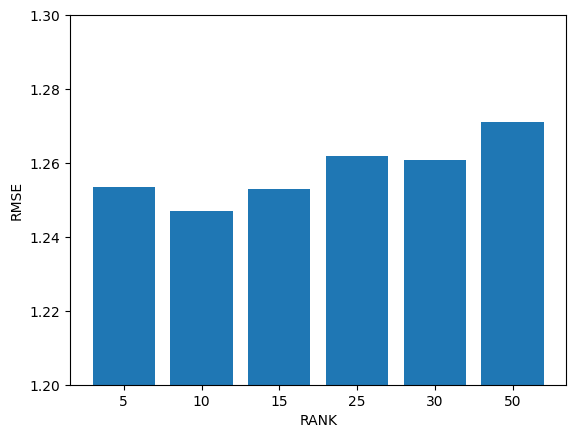

In [18]:
plt.bar(['5', '10', '15', '25', '30', '50'], cv_model.avgMetrics)
plt.ylim(1.2, 1.3)
plt.ylabel('RMSE')
plt.xlabel('RANK')

In [19]:
# Get the best model
best_model = cv_model.bestModel
# Get the rank of the best model
best_model.rank

10

In [17]:
best_model.save("../models/als_model")

In [20]:
best_model.itemFactors.show()

+---+--------------------+
| id|            features|
+---+--------------------+
| 20|[0.3963369, 1.125...|
| 30|[-0.86721945, 1.4...|
| 50|[-0.26204997, 1.1...|
| 60|[0.050949614, 0.9...|
| 80|[0.24611104, 1.48...|
| 90|[0.1574142, 1.202...|
|100|[0.23665363, 0.96...|
|110|[0.19942038, 1.19...|
|120|[0.4508344, 1.090...|
|130|[0.71206963, 0.42...|
|150|[0.020531598, 0.9...|
|160|[-0.01816241, 1.1...|
|170|[0.41517526, 1.34...|
|180|[0.05407523, 0.86...|
|190|[-0.19890136, 0.8...|
|200|[0.12387429, 0.86...|
|210|[-0.009281533, 1....|
|220|[-0.8095619, -0.0...|
|230|[-0.07211917, 0.5...|
|240|[0.0368624, 1.022...|
+---+--------------------+
only showing top 20 rows



In [20]:
rmse = evaluator.evaluate(best_model.transform(test_set))
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 1.2342946311853595


In [11]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel

# Build new model to tuning
maxIter_als = ALS(rank=10, userCol="user_id", itemCol="anime_id", ratingCol="rating", coldStartStrategy="drop")

# Construct a grid of parameters to search over the list of maxIter
param_grid = ParamGridBuilder() \
                .addGrid(maxIter_als.maxIter, [5, 10, 15, 16, 18]) \
                .build()

# Use rmse to see how well a fitted model performs
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating")

crossval = CrossValidator(estimator=maxIter_als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)

maxIter_cv_model = crossval.fit(train_set)

24/08/14 17:03:43 WARN CacheManager: Asked to cache already cached data.
24/08/14 17:03:43 WARN CacheManager: Asked to cache already cached data.


Py4JJavaError: An error occurred while calling o2107.evaluate.
: java.lang.StackOverflowError
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeArray(ObjectOutputStream.java:1369)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1165)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeArray(ObjectOutputStream.java:1369)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1165)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeArray(ObjectOutputStream.java:1369)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1165)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeArray(ObjectOutputStream.java:1369)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1165)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeArray(ObjectOutputStream.java:1369)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1165)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeArray(ObjectOutputStream.java:1369)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1165)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.writeObject(ObjectOutputStream.java:345)
	at scala.collection.immutable.List$SerializationProxy.writeObject(List.scala:516)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at java.base/java.io.ObjectStreamClass.invokeWriteObject(ObjectStreamClass.java:1016)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1487)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)
	at java.base/java.io.ObjectOutputStream.writeObject0(ObjectOutputStream.java:1169)
	at java.base/java.io.ObjectOutputStream.defaultWriteFields(ObjectOutputStream.java:1543)
	at java.base/java.io.ObjectOutputStream.writeSerialData(ObjectOutputStream.java:1500)
	at java.base/java.io.ObjectOutputStream.writeOrdinaryObject(ObjectOutputStream.java:1423)


In [9]:
# [1.2962606302138129, 1.2571076414148117, 1.2395689978648778, 1.2366712019073702, 1.234122851740356]
maxIter_cv_model.avgMetrics

[np.float64(1.234122851740356)]

Text(0.5, 0, 'MAX ITERATION')

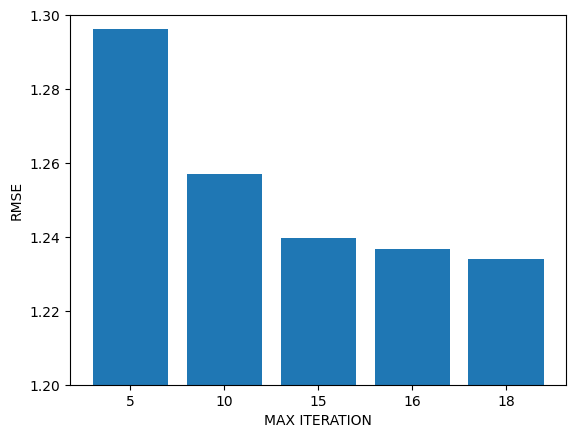

In [14]:
plt.bar(['5', '10', '15', '16', '18'], [1.2962606302138129, 1.2571076414148117, 1.2395689978648778, 1.2366712019073702, 1.234122851740356])
plt.ylim(1.2, 1.3)
plt.ylabel('RMSE')
plt.xlabel('MAX ITERATION')

In [40]:
als = ALS(
    maxIter = 15, 
    rank = best_model.rank, 
    userCol="user_id", 
    itemCol="anime_id", 
    ratingCol="rating", 
    coldStartStrategy="drop"
)

training_model = als.fit(train_set)

predictions = training_model.transform(test_set)

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 1.2213078815765972


In [ ]:
als = ALS(
    maxIter = 20, 
    rank = best_model.rank, 
    userCol="user_id", 
    itemCol="anime_id", 
    ratingCol="rating", 
    coldStartStrategy="drop"
)

training_model = als.fit(train_set)

predictions = training_model.transform(test_set)

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))